In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from ADC.ste import ste_round, ste_floor # Import from your ste.py
from ADC.quantizers import ADCQuantizer, ADCQuantizerAshift
from scipy.stats import laplace

In [27]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def quantize_uniform_core(x, n_bits, round_fn, data_min_val, data_max_val):
    """
    Core uniform quantization logic. Returns dequantized values and integer levels.
    """
    data_min = torch.tensor(data_min_val, device=x.device, dtype=x.dtype)
    data_max = torch.tensor(data_max_val, device=x.device, dtype=x.dtype)
    num_levels = 2**n_bits

    if num_levels <= 1 or (data_max - data_min).abs() < 1e-9:
        levels_int = torch.zeros_like(x, dtype=torch.float32) # float for consistency
        dequant_val = torch.full_like(x, data_min)
        return dequant_val, levels_int

    scale = (data_max - data_min) / (num_levels - 1)
    
    x_clamped_input = torch.clamp(x, data_min, data_max)
    x_transformed = (x_clamped_input - data_min) / scale
    
    quantized_levels_float = round_fn(x_transformed)
    quantized_levels_int = torch.clamp(quantized_levels_float, 0, num_levels - 1)
    
    x_dequant = quantized_levels_int * scale + data_min
    # Shift levels for symmetric to be centered around 0 if desired for interpretation
    # For this analysis, levels 0 to N-1 are fine.
    return x_dequant, quantized_levels_int.to(torch.float32)

In [4]:
def quantize_elementwise(data, n_bits, quant_type, round_fn):
    if quant_type == 'affine':
        min_val, max_val = data.min().item(), data.max().item()
        if max_val <= min_val + 1e-9: max_val = min_val + 1.0
    elif quant_type == 'symmetric':
        abs_max = data.abs().max().item()
        min_val, max_val = -abs_max, abs_max
        if max_val <= min_val + 1e-9 : 
            min_val = -1.0 # Default small range if data is all zero
            max_val = 1.0
    else:
        raise ValueError("quant_type must be 'affine' or 'symmetric'")
    
    return quantize_uniform_core(data, n_bits, round_fn, min_val, max_val)

In [5]:
def generate_normal_data(num_samples, mean=0.0, std=0.1):
    return torch.randn(num_samples) * std + mean, f"Normal (μ={mean:.2f}, σ={std:.2f})"

def generate_exponential_data(num_samples, rate=1.0):
    return torch.distributions.Exponential(rate).sample((num_samples,)), f"Exponential (rate={rate:.1f})"

In [18]:
def run_product_quantization_comparison(bw=4, bx=4, ba=8, k_adc=4, num_samples=10000):
    print(f"\n--- Product Quantization Comparison ---")
    print(f"Params: w_bits={bw}, x_bits={bx}, final_product_bits={ba}, adc_k={k_adc}, Samples={num_samples}")

    w_orig, w_dist_name = generate_normal_data(num_samples, std=0.05)
    x_orig, x_dist_name = generate_exponential_data(num_samples, rate=0.5) # Mean = 2

    # --- Method 1: Standard Quantization of Product ---
    w_std_dequant_for_prod, _ = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=torch.round)
    x_std_dequant_for_prod, _ = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=torch.round)
    product_for_std_quant = w_std_dequant_for_prod * x_std_dequant_for_prod
    # Quantize the product itself to 'ba' bits using affine quantization and standard round
    _, product_std_quant_levels = quantize_elementwise(product_for_std_quant, n_bits=ba, quant_type='affine', round_fn=torch.round)

    # --- Method 2: ADC-Style (STE-Floor for w,x pre-quant) ---
    w_floor_inter_dequant, w_floor_inter_levels = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=ste_floor)
    x_floor_inter_dequant, x_floor_inter_levels = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=ste_floor)
    product_input_to_adc_floor = w_floor_inter_dequant * x_floor_inter_dequant
    adc_module_floor = ADCQuantizer(M=1, bx=bx, bw=bw, ba=ba, k=k_adc) # M=1 for element-wise product
    adc_floor_output_levels = adc_module_floor(product_input_to_adc_floor)

    # --- Method 3: ADC-Style (STE-Round for w,x pre-quant) ---
    w_round_inter_dequant, w_round_inter_levels = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=ste_round)
    x_round_inter_dequant, x_round_inter_levels = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=ste_round)
    product_input_to_adc_round = w_round_inter_dequant * x_round_inter_dequant
    adc_module_round = ADCQuantizer(M=1, bx=bx, bw=bw, ba=ba, k=k_adc) 
    adc_round_output_levels = adc_module_round(product_input_to_adc_round)
    
    print("\n  --- Product Bin Counts (all target 'ba' bits) ---")
    print(f"    Standard Product Quant (affine, round) bins: {len(torch.unique(product_std_quant_levels))}")
    print(f"    ADC Output (pre w,x quant w/ STE-Floor) bins: {len(torch.unique(adc_floor_output_levels))}")
    print(f"    ADC Output (pre w,x quant w/ STE-Round) bins: {len(torch.unique(adc_round_output_levels))}")
    print(f"  --- Intermediate Quantized W/X Bin Counts ---")
    print(f"    Intermediate W (symm, STE-Floor, {bw}-bit) bins: {len(torch.unique(w_floor_inter_levels))}")
    print(f"    Intermediate X (aff, STE-Floor, {bx}-bit) bins: {len(torch.unique(x_floor_inter_levels))}")

    # --- Visualization ---
    fig, axes = plt.subplots(3, 3, figsize=(20, 16)) # Now 3 rows
    title_str = (f"Product Quantization Bin Comparison ({ba}-bit output)\n"
                 f"Inputs: w ({bw}b-symm), x ({bx}b-aff). ADC M=1, k={k_adc}")
    fig.suptitle(title_str, fontsize=15)

    # Row 0: Originals 
    axes[0, 0].hist(w_orig.cpu().numpy(), bins=100, color='gray', alpha=0.7, density=True)
    axes[0, 0].set_title(f"Original W ({w_dist_name})")
    axes[0, 0].grid(True)

    axes[0, 1].hist(x_orig.cpu().numpy(), bins=100, color='skyblue', alpha=0.7, density=True)
    axes[0, 1].set_title(f"Original X ({x_dist_name})")
    axes[0, 1].grid(True)
    axes[0, 2].axis('off') # Keep one empty for layout or future use

    # Helper for plotting levels (bins)
    def plot_levels(ax, levels_data, title, color, is_dequant_plot=False):
        unique_vals, counts = torch.unique(levels_data, return_counts=True)
        bar_width = 0.8 
        if len(unique_vals) > 1:
            min_diff = (torch.sort(unique_vals).values[1:] - torch.sort(unique_vals).values[:-1]).min().item()
            # For dequantized values, which are continuous-like, or many bins, use hist
            if is_dequant_plot or len(unique_vals) > 2 * (2**max(bw,bx,ba)): # Heuristic for hist
                ax.hist(levels_data.cpu().numpy(), bins=50, color=color, alpha=0.8, density=True)
            else: # For few discrete levels, use bar
                bar_width = min_diff * 0.8 if min_diff > 1e-6 else 0.8 # Ensure positive width for bars
                if bar_width < 1e-5: bar_width = 0.05 * (unique_vals.abs().mean().item() if len(unique_vals)>0 else 1.0)
                if bar_width < 1e-5: bar_width = 0.05
                ax.bar(unique_vals.cpu().numpy(), (counts.cpu().numpy() / num_samples), 
                       width=bar_width, color=color, alpha=0.85)
        elif len(unique_vals) == 1: 
             bar_width = 0.05 * abs(unique_vals.item()) if abs(unique_vals.item()) > 0 else 0.05
             if bar_width == 0: bar_width = 0.05
             ax.bar(unique_vals.cpu().numpy(), (counts.cpu().numpy() / num_samples), 
                    width=bar_width, color=color, alpha=0.85)
        else: # No data or no unique values
            ax.text(0.5, 0.5, "No data/bins", ha="center", va="center")


        ax.set_title(f"{title}\nUnique Bins/Values: {len(unique_vals)}")
        ax.set_ylabel("Normalized Freq. / Density")
        ax.grid(True)

    # Row 1: Intermediately Quantized W, X (using STE-Floor for ADC path example) and a Product Input
    # Plotting dequantized values here to see their distribution before product
    plot_levels(axes[1, 0], w_floor_inter_dequant, f"Intermed. Quant W ({bw}b, STE-Floor)\n(Dequantized)", 'darkblue', is_dequant_plot=True)
    plot_levels(axes[1, 1], x_floor_inter_dequant, f"Intermed. Quant X ({bx}b, STE-Floor)\n(Dequantized)", 'darkgreen', is_dequant_plot=True)
    axes[1, 2].axis('off')


    # Row 2: Final Product Quantized Levels (Bins) from the three methods
    plot_levels(axes[2, 0], product_std_quant_levels, f"Std. Product Quant Levels ({ba}-bit)\n(Affine, torch.round)", 'purple')
    plot_levels(axes[2, 1], adc_floor_output_levels, f"ADC Output Levels ({ba}-bit)\n(Pre w,x STE-Floor)", 'teal')
    plot_levels(axes[2, 2], adc_round_output_levels, f"ADC Output Levels ({ba}-bit)\n(Pre w,x STE-Round)", 'orangered')
    
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel("Value / Level")

    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    output_dir = os.path.join("ADC", "analysis_results")
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"product_quant_compare_w{bw}x{bx}_out{ba}_k{k_adc}.png")
    plt.savefig(plot_filename)
    print(f"\nPlot saved to {plot_filename}")
    plt.close()

In [19]:
run_product_quantization_comparison(bw=8, bx=8, ba=8, k_adc=4)


--- Product Quantization Comparison ---
Params: w_bits=8, x_bits=8, final_product_bits=8, adc_k=4, Samples=10000

  --- Product Bin Counts (all target 'ba' bits) ---
    Standard Product Quant (affine, round) bins: 144
    ADC Output (pre w,x quant w/ STE-Floor) bins: 2
    ADC Output (pre w,x quant w/ STE-Round) bins: 2
  --- Intermediate Quantized W/X Bin Counts ---
    Intermediate W (symm, STE-Floor, 8-bit) bins: 186
    Intermediate X (aff, STE-Floor, 8-bit) bins: 153

Plot saved to ADC/analysis_results/product_quant_compare_w8x8_out8_k4.png


In [24]:
def run_product_quantization_comparison(bw=4, bx=4, ba=8, k_adc=4, num_samples=10000):
    print(f"\n--- Product Quantization Comparison ---")
    print(f"Params: w_bits={bw}, x_bits={bx}, final_product_bits={ba}, adc_k={k_adc}, Samples={num_samples}")

    w_orig, w_dist_name = generate_normal_data(num_samples, std=0.05)
    x_orig, x_dist_name = generate_exponential_data(num_samples, rate=0.5) # Mean = 2

    # --- Method 1: Standard Quantization of Product ---
    w_std_dequant_for_prod, _ = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=torch.round)
    x_std_dequant_for_prod, _ = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=torch.round)
    product_for_std_quant = w_std_dequant_for_prod * x_std_dequant_for_prod
    # Quantize the product itself to 'ba' bits using affine quantization and standard round
    _, product_std_quant_levels = quantize_elementwise(product_for_std_quant, n_bits=ba, quant_type='affine', round_fn=torch.round)

    # --- Method 2: ADC-Style (STE-Floor for w,x pre-quant), Original ADCQuantizer ---
    w_floor_inter_dequant, w_floor_inter_levels = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=ste_floor)
    x_floor_inter_dequant, x_floor_inter_levels = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=ste_floor)
    product_input_to_adc_floor = w_floor_inter_dequant * x_floor_inter_dequant
    adc_module_orig_floor = ADCQuantizer(M=1, bx=bx, bw=bw, ba=ba, k=k_adc) 
    adc_orig_floor_output_levels = adc_module_orig_floor(product_input_to_adc_floor)

    # --- Method 3: ADC-Style (STE-Round for w,x pre-quant), Original ADCQuantizer ---
    w_round_inter_dequant, w_round_inter_levels = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=ste_round)
    x_round_inter_dequant, x_round_inter_levels = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=ste_round)
    product_input_to_adc_round = w_round_inter_dequant * x_round_inter_dequant
    adc_module_orig_round = ADCQuantizer(M=1, bx=bx, bw=bw, ba=ba, k=k_adc) 
    adc_orig_round_output_levels = adc_module_orig_round(product_input_to_adc_round)
    
    # --- Method 4: ADC-Ashift-Style (STE-Round for w,x pre-quant), ADCQuantizerAshift ---
    # Use w_round_inter_dequant and x_round_inter_dequant (calculated for Method 3)
    # product_input_to_adc_ashift_round is the same as product_input_to_adc_round
    adc_module_ashift_round = ADCQuantizerAshift(M=1, bx=bx, bw=bw, ba=ba, k=k_adc, ashift_enabled=True)
    adc_ashift_round_output_levels = adc_module_ashift_round(product_input_to_adc_round) # Use product from STE-Round inputs
    
    print("\n  --- Product Bin Counts (all target 'ba' bits) ---")
    print(f"    Standard Product Quant (affine, round) bins: {len(torch.unique(product_std_quant_levels))}")
    print(f"    Orig. ADC (pre w,x STE-Floor) bins: {len(torch.unique(adc_orig_floor_output_levels))}")
    print(f"    Orig. ADC (pre w,x STE-Round) bins: {len(torch.unique(adc_orig_round_output_levels))}")
    print(f"    Ashift ADC (pre w,x STE-Round) bins: {len(torch.unique(adc_ashift_round_output_levels))}") # Updated name
    print(f"  --- Intermediate Quantized W/X Bin Counts ---")
    print(f"    Intermediate W (symm, STE-Floor, {bw}-bit) bins: {len(torch.unique(w_floor_inter_levels))}") # For context for method 2
    print(f"    Intermediate X (aff, STE-Floor, {bx}-bit) bins: {len(torch.unique(x_floor_inter_levels))}") # For context for method 2
    print(f"    Intermediate W (symm, STE-Round, {bw}-bit) bins: {len(torch.unique(w_round_inter_levels))}") # For context for methods 3 & 4
    print(f"    Intermediate X (aff, STE-Round, {bx}-bit) bins: {len(torch.unique(x_round_inter_levels))}") # For context for methods 3 & 4

    # --- Visualization ---
    fig, axes = plt.subplots(4, 3, figsize=(20, 20)) 
    title_str = (f"Product Quantization Bin Comparison ({ba}-bit output)\n"
                 f"Inputs: w ({bw}b-symm), x ({bx}b-aff). ADC M=1, k={k_adc}")
    fig.suptitle(title_str, fontsize=15)

    # Row 0: Originals 
    axes[0, 0].hist(w_orig.cpu().numpy(), bins=100, color='gray', alpha=0.7, density=True)
    axes[0, 0].set_title(f"Original W ({w_dist_name})")
    axes[0, 0].grid(True)

    axes[0, 1].hist(x_orig.cpu().numpy(), bins=100, color='skyblue', alpha=0.7, density=True)
    axes[0, 1].set_title(f"Original X ({x_dist_name})")
    axes[0, 1].grid(True)
    axes[0, 2].axis('off') 

    # Helper for plotting levels (bins)
    def plot_levels(ax, levels_data, title, color, is_dequant_plot=False):
        unique_vals, counts = torch.unique(levels_data, return_counts=True)
        bar_width = 0.8 
        if len(unique_vals) > 1:
            min_diff = (torch.sort(unique_vals).values[1:] - torch.sort(unique_vals).values[:-1]).min().item()
            if is_dequant_plot or len(unique_vals) > 2 * (2**max(bw,bx,ba)): 
                ax.hist(levels_data.cpu().numpy(), bins=50, color=color, alpha=0.8, density=True)
            else: 
                bar_width = min_diff * 0.8 if min_diff > 1e-6 else 0.8 
                if bar_width < 1e-5: bar_width = 0.05 * (unique_vals.abs().mean().item() if len(unique_vals)>0 else 1.0)
                if bar_width < 1e-5: bar_width = 0.05
                ax.bar(unique_vals.cpu().numpy(), (counts.cpu().numpy() / num_samples), 
                       width=bar_width, color=color, alpha=0.85)
        elif len(unique_vals) == 1: 
             bar_width = 0.05 * abs(unique_vals.item()) if abs(unique_vals.item()) > 0 else 0.05
             if bar_width == 0: bar_width = 0.05
             ax.bar(unique_vals.cpu().numpy(), (counts.cpu().numpy() / num_samples), 
                    width=bar_width, color=color, alpha=0.85)
        else: 
            ax.text(0.5, 0.5, "No data/bins", ha="center", va="center")
        ax.set_title(f"{title}\nUnique Bins/Values: {len(unique_vals)}")
        ax.set_ylabel("Normalized Freq. / Density")
        ax.grid(True)

    # Row 1: Intermediately Quantized W, X (using STE-Round for ADC Ashift path example) 
    plot_levels(axes[1, 0], w_round_inter_dequant, f"Intermed. Quant W ({bw}b, STE-Round)\n(Dequantized)", 'darkslateblue', is_dequant_plot=True)
    plot_levels(axes[1, 1], x_round_inter_dequant, f"Intermed. Quant X ({bx}b, STE-Round)\n(Dequantized)", 'seagreen', is_dequant_plot=True)
    axes[1, 2].axis('off')


    # Row 2: Product Quantized Levels (Bins) - Part 1
    plot_levels(axes[2, 0], product_std_quant_levels, f"Std. Product Quant Levels ({ba}-bit)\n(Affine, torch.round)", 'purple')
    plot_levels(axes[2, 1], adc_orig_floor_output_levels, f"Orig. ADC Output ({ba}-bit)\n(Pre w,x STE-Floor)", 'teal')
    axes[2, 2].axis('off') 

    # Row 3: Product Quantized Levels (Bins) - Part 2
    plot_levels(axes[3, 0], adc_orig_round_output_levels, f"Orig. ADC Output ({ba}-bit)\n(Pre w,x STE-Round)", 'orangered')
    plot_levels(axes[3, 1], adc_ashift_round_output_levels, f"Ashift ADC Output ({ba}-bit)\n(Pre w,x STE-Round)", 'saddlebrown') # Updated title
    axes[3, 2].axis('off')
    
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel("Value / Level")

    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    output_dir = os.path.join("ADC", "analysis_results")
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"product_quant_compare_w{bw}x{bx}_out{ba}_k{k_adc}.png")
    plt.savefig(plot_filename)
    print(f"\nPlot saved to {plot_filename}")
    plt.close()

In [25]:
run_product_quantization_comparison(bw=8, bx=8, ba=8, k_adc=4)


--- Product Quantization Comparison ---
Params: w_bits=8, x_bits=8, final_product_bits=8, adc_k=4, Samples=10000

  --- Product Bin Counts (all target 'ba' bits) ---
    Standard Product Quant (affine, round) bins: 164
    Orig. ADC (pre w,x STE-Floor) bins: 2
    Orig. ADC (pre w,x STE-Round) bins: 2
    Ashift ADC (pre w,x STE-Round) bins: 2
  --- Intermediate Quantized W/X Bin Counts ---
    Intermediate W (symm, STE-Floor, 8-bit) bins: 202
    Intermediate X (aff, STE-Floor, 8-bit) bins: 175
    Intermediate W (symm, STE-Round, 8-bit) bins: 199
    Intermediate X (aff, STE-Round, 8-bit) bins: 176

Plot saved to ADC/analysis_results/product_quant_compare_w8x8_out8_k4.png


---

In [28]:
def generate_laplace_data_for_weights(num_samples, loc=0.0, scale=0.03): # scale is b for Laplace
    # Scale chosen to have a somewhat comparable spread to normal std=0.05
    # Variance of Laplace is 2*scale^2. Std dev = sqrt(2)*scale.
    # For std_dev ~ 0.05, sqrt(2)*scale = 0.05 => scale = 0.05/sqrt(2) ~ 0.035
    return torch.tensor(laplace.rvs(loc=loc, scale=scale, size=num_samples), dtype=torch.float32), \
           f"Laplace Weights (loc={loc:.2f}, scale={scale:.3f})"

In [29]:
def generate_clipped_sum_normals_data_for_weights(num_samples, 
                                                 mean1=-0.05, std1=0.03, 
                                                 mean2=0.05, std2=0.03, 
                                                 clip_std_factor=1.5):
    n_half = num_samples // 2
    dist1 = torch.randn(n_half) * std1 + mean1
    dist2 = torch.randn(num_samples - n_half) * std2 + mean2
    
    # Clip tails
    clip_min1, clip_max1 = mean1 - clip_std_factor * std1, mean1 + clip_std_factor * std1
    clip_min2, clip_max2 = mean2 - clip_std_factor * std2, mean2 + clip_std_factor * std2
    
    dist1_clipped = torch.clamp(dist1, clip_min1, clip_max1)
    dist2_clipped = torch.clamp(dist2, clip_min2, clip_max2)
    
    # For sum, we can take samples from each and sum, or just create a mixed distribution
    # The description implies "sum of 2 normal that after the sum will not have their left and right tails"
    # This interpretation is a bit ambiguous. Let's create a bimodal-like distribution by concatenating
    # two normals that are themselves somewhat "flattened" by clipping, or more directly,
    # a sum that results in a flatter top.
    # A simpler approach to get a "flatter" distribution is to reduce kurtosis.
    # For this example, let's try a sum that might spread out.
    # Or, to ensure no extreme tails after sum, we could sum and then clip the sum.
    # Let's try a bimodal by concatenation of two slightly offset distributions,
    # which might not be exactly "sum of 2 normals" but achieves a flatter, wider shape.
    # Re-interpreting: "sum of 2 normal that after the sum will not have their left and right tails"
    # This could mean (N1_clipped + N2_clipped) / 2 or similar.
    # For simplicity and to ensure a different shape: let's try a mixture.
    
    # Alternative interpretation for "sum of 2 normal that after the sum will not have their left and right tails"
    # Generate N(0, sigma_base), then transform it to be flatter.
    # For now, let's make a bimodal by concatenating two slightly offset distributions.
    # This aims for a distribution with more mass at the edges of a central region.
    offset = 0.06
    std_base = 0.02
    w1 = torch.randn(n_half) * std_base - offset
    w2 = torch.randn(num_samples - n_half) * std_base + offset
    weights = torch.cat((w1, w2))
    # Further clip the combined distribution to ensure no extreme tails after forming bimodal
    final_clip_val = offset + 2.5 * std_base
    weights = torch.clamp(weights, -final_clip_val, final_clip_val)

    return weights, f"Bimodal-like Weights (No extreme tails)"

In [56]:
import torch

def generate_u_shaped_weights(
    num_samples: int,
    center_gap: float = 5.0,
    spread: float = 4.0,
    noise_std: float = 0.2,
    middle_ratio: float = 0.5
):
    """
    Генерирует U-образное распределение с двумя "пиками" по краям 
    и достаточно равномерными данными между ними.

    Параметры:
        num_samples   — общее число точек
        center_gap    — полуширина пустой зоны (зазора) вокруг 0
        spread        — расширение от края зазора до пиков
        noise_std     — стандартное отклонение добавляемого шума
        middle_ratio  — доля точек, попадающих в середину (между пиками)

    Возвращает:
        weights       — Tensor размера (num_samples,) с U-образным распределением
        description   — строка с описанием распределения
    """
    # сколько точек в средней (равномерной) зоне
    n_middle = int(num_samples * middle_ratio)
    # остаток делим пополам для левой и правой части
    n_side = num_samples - n_middle
    n_left  = n_side // 2
    n_right = n_side - n_left

    # левая часть: uniform на [-(spread+center_gap), -center_gap]
    left = torch.empty(n_left).uniform_(-spread - center_gap, -center_gap)
    # средняя часть: uniform на [-center_gap, +center_gap]
    middle = torch.empty(n_middle).uniform_(-center_gap, center_gap)
    # правая часть: uniform на [center_gap, spread+center_gap]
    right = torch.empty(n_right).uniform_(center_gap, spread + center_gap)

    # объединяем и добавляем мелкий шум
    weights = torch.cat([left, middle, right])
    weights += torch.randn_like(weights) * noise_std

    description = "U-shaped Bimodal Distribution with Uniform Middle"
    return weights, description

# Пример использования:
# weights, desc = generate_u_shaped_weights(10000, middle_ratio=0.4)
# plt.hist(weights.numpy(), bins=300)
# plt.title(desc)
# plt.show()


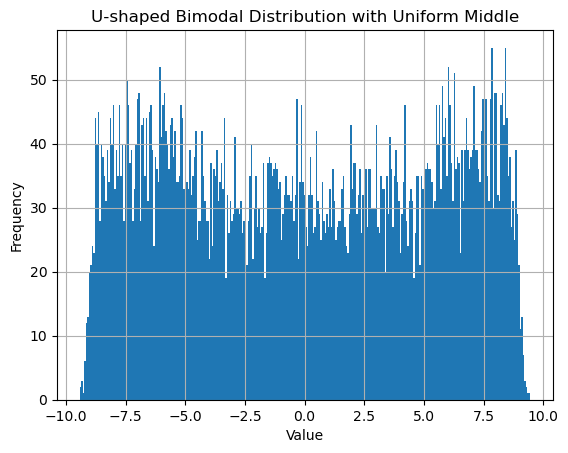

In [57]:
weights, description = generate_u_shaped_weights(10000)
plt.hist(weights.numpy(), bins=300)
plt.title(description)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [30]:
def generate_exponential_data_for_activations(num_samples, rate=1.0): # Renamed for clarity
    return torch.distributions.Exponential(rate).sample((num_samples,)), f"Exponential Activations (rate={rate:.1f})"


In [31]:
def generate_normal_data_for_weights(num_samples, mean=0.0, std=0.05): # Renamed for clarity
    return torch.randn(num_samples) * std + mean, f"Normal Weights (μ={mean:.2f}, σ={std:.2f})"


In [58]:
def run_product_quantization_comparison(w_generator_fn, bw=4, bx=4, ba=8, k_adc=4, num_samples=10000, plot_suffix=""):
    print(f"\n--- Product Quantization Comparison ({plot_suffix.replace('_', ' ')}) ---")
    print(f"Params: w_bits={bw}, x_bits={bx}, final_product_bits={ba}, adc_k={k_adc}, Samples={num_samples}")

    w_orig, w_dist_name = w_generator_fn(num_samples)
    x_orig, x_dist_name = generate_exponential_data_for_activations(num_samples, rate=0.5) # Mean = 2

    # --- Method 1: Standard Quantization of Product ---
    w_std_dequant_for_prod, _ = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=torch.round)
    x_std_dequant_for_prod, _ = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=torch.round)
    product_for_std_quant = w_std_dequant_for_prod * x_std_dequant_for_prod
    _, product_std_quant_levels = quantize_elementwise(product_for_std_quant, n_bits=ba, quant_type='affine', round_fn=torch.round)

    # --- Method 2: ADC-Style (STE-Floor for w,x pre-quant), Original ADCQuantizer ---
    w_floor_inter_dequant, w_floor_inter_levels = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=ste_floor)
    x_floor_inter_dequant, x_floor_inter_levels = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=ste_floor)
    product_input_to_adc_floor = w_floor_inter_dequant * x_floor_inter_dequant
    adc_module_orig_floor = ADCQuantizer(M=1, bx=bx, bw=bw, ba=ba, k=k_adc) 
    adc_orig_floor_output_levels = adc_module_orig_floor(product_input_to_adc_floor)

    # --- Method 3: ADC-Style (STE-Round for w,x pre-quant), Original ADCQuantizer ---
    w_round_inter_dequant, w_round_inter_levels = quantize_elementwise(w_orig, n_bits=bw, quant_type='symmetric', round_fn=ste_round)
    x_round_inter_dequant, x_round_inter_levels = quantize_elementwise(x_orig, n_bits=bx, quant_type='affine', round_fn=ste_round)
    product_input_to_adc_round = w_round_inter_dequant * x_round_inter_dequant
    adc_module_orig_round = ADCQuantizer(M=1, bx=bx, bw=bw, ba=ba, k=k_adc) 
    adc_orig_round_output_levels = adc_module_orig_round(product_input_to_adc_round)
    
    # --- Method 4: ADC-Ashift-Style (STE-Round for w,x pre-quant), ADCQuantizerAshift ---
    adc_module_ashift_round = ADCQuantizerAshift(M=1, bx=bx, bw=bw, ba=ba, k=k_adc, ashift_enabled=True)
    adc_ashift_round_output_levels = adc_module_ashift_round(product_input_to_adc_round) 
    
    print("\n  --- Product Bin Counts (all target 'ba' bits) ---")
    print(f"    Standard Product Quant (affine, round) bins: {len(torch.unique(product_std_quant_levels))}")
    print(f"    Orig. ADC (pre w,x STE-Floor) bins: {len(torch.unique(adc_orig_floor_output_levels))}")
    print(f"    Orig. ADC (pre w,x STE-Round) bins: {len(torch.unique(adc_orig_round_output_levels))}")
    print(f"    Ashift ADC (pre w,x STE-Round) bins: {len(torch.unique(adc_ashift_round_output_levels))}")
    print(f"  --- Intermediate Quantized W/X Bin Counts ---")
    print(f"    Intermediate W (symm, STE-Floor, {bw}-bit) bins: {len(torch.unique(w_floor_inter_levels))}")
    print(f"    Intermediate X (aff, STE-Floor, {bx}-bit) bins: {len(torch.unique(x_floor_inter_levels))}")
    print(f"    Intermediate W (symm, STE-Round, {bw}-bit) bins: {len(torch.unique(w_round_inter_levels))}")
    print(f"    Intermediate X (aff, STE-Round, {bx}-bit) bins: {len(torch.unique(x_round_inter_levels))}")

    fig, axes = plt.subplots(4, 3, figsize=(20, 20)) 
    title_str = (f"Product Quantization ({plot_suffix.replace('_', ' ')}) ({ba}-bit output)\n"
                 f"Inputs: w ({bw}b-symm), x ({bx}b-aff). ADC M=1, k={k_adc}")
    fig.suptitle(title_str, fontsize=15)

    axes[0, 0].hist(w_orig.cpu().numpy(), bins=100, color='gray', alpha=0.7, density=True)
    axes[0, 0].set_title(f"Original W ({w_dist_name})")
    axes[0, 0].grid(True)

    axes[0, 1].hist(x_orig.cpu().numpy(), bins=100, color='skyblue', alpha=0.7, density=True)
    axes[0, 1].set_title(f"Original X ({x_dist_name})")
    axes[0, 1].grid(True)
    axes[0, 2].axis('off') 

    def plot_levels(ax, levels_data, title, color, is_dequant_plot=False):
        unique_vals, counts = torch.unique(levels_data, return_counts=True)
        bar_width = 0.8 
        if len(unique_vals) > 1:
            min_diff = (torch.sort(unique_vals).values[1:] - torch.sort(unique_vals).values[:-1]).min().item()
            if is_dequant_plot or len(unique_vals) > 2 * (2**max(bw,bx,ba)): 
                ax.hist(levels_data.cpu().numpy(), bins=50, color=color, alpha=0.8, density=True)
            else: 
                bar_width = min_diff * 0.8 if min_diff > 1e-6 else 0.8 
                if bar_width < 1e-5: bar_width = 0.05 * (unique_vals.abs().mean().item() if len(unique_vals)>0 else 1.0)
                if bar_width < 1e-5: bar_width = 0.05
                ax.bar(unique_vals.cpu().numpy(), (counts.cpu().numpy() / num_samples), 
                       width=bar_width, color=color, alpha=0.85)
        elif len(unique_vals) == 1: 
             bar_width = 0.05 * abs(unique_vals.item()) if abs(unique_vals.item()) > 0 else 0.05
             if bar_width == 0: bar_width = 0.05
             ax.bar(unique_vals.cpu().numpy(), (counts.cpu().numpy() / num_samples), 
                    width=bar_width, color=color, alpha=0.85)
        else: 
            ax.text(0.5, 0.5, "No data/bins", ha="center", va="center")
        ax.set_title(f"{title}\nUnique Bins/Values: {len(unique_vals)}")
        ax.set_ylabel("Normalized Freq. / Density")
        ax.grid(True)

    plot_levels(axes[1, 0], w_round_inter_dequant, f"Intermed. Quant W ({bw}b, STE-Round)\n(Dequantized)", 'darkslateblue', is_dequant_plot=True)
    plot_levels(axes[1, 1], x_round_inter_dequant, f"Intermed. Quant X ({bx}b, STE-Round)\n(Dequantized)", 'seagreen', is_dequant_plot=True)
    axes[1, 2].axis('off')

    plot_levels(axes[2, 0], product_std_quant_levels, f"Std. Product Quant Levels ({ba}-bit)\n(Affine, torch.round)", 'purple')
    plot_levels(axes[2, 1], adc_orig_floor_output_levels, f"Orig. ADC Output ({ba}-bit)\n(Pre w,x STE-Floor)", 'teal')
    axes[2, 2].axis('off') 

    plot_levels(axes[3, 0], adc_orig_round_output_levels, f"Orig. ADC Output ({ba}-bit)\n(Pre w,x STE-Round)", 'orangered')
    plot_levels(axes[3, 1], adc_ashift_round_output_levels, f"Ashift ADC Output ({ba}-bit)\n(Pre w,x STE-Round)", 'saddlebrown') 
    axes[3, 2].axis('off')
    
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel("Value / Level")

    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    output_dir = os.path.join("ADC", "analysis_results")
    os.makedirs(output_dir, exist_ok=True)
    # Include plot_suffix in filename
    filename_core = f"product_quant_compare_w{bw}x{bx}_out{ba}_k{k_adc}"
    plot_filename = os.path.join(output_dir, f"{filename_core}{plot_suffix}.png")
    plt.savefig(plot_filename)
    print(f"\nPlot saved to {plot_filename}")
    plt.close()

In [59]:
common_params = {'bw': 8, 'bx': 8, 'ba': 8, 'k_adc': 4, 'num_samples': 10000}
    
run_product_quantization_comparison(generate_normal_data_for_weights, **common_params, plot_suffix="_normal_weights")
run_product_quantization_comparison(generate_laplace_data_for_weights, **common_params, plot_suffix="_laplace_weights")
run_product_quantization_comparison(generate_u_shaped_weights, **common_params, plot_suffix="_bimodal_weights")



--- Product Quantization Comparison ( normal weights) ---
Params: w_bits=8, x_bits=8, final_product_bits=8, adc_k=4, Samples=10000

  --- Product Bin Counts (all target 'ba' bits) ---
    Standard Product Quant (affine, round) bins: 165
    Orig. ADC (pre w,x STE-Floor) bins: 2
    Orig. ADC (pre w,x STE-Round) bins: 2
    Ashift ADC (pre w,x STE-Round) bins: 2
  --- Intermediate Quantized W/X Bin Counts ---
    Intermediate W (symm, STE-Floor, 8-bit) bins: 204
    Intermediate X (aff, STE-Floor, 8-bit) bins: 168
    Intermediate W (symm, STE-Round, 8-bit) bins: 205
    Intermediate X (aff, STE-Round, 8-bit) bins: 171

Plot saved to ADC/analysis_results/product_quant_compare_w8x8_out8_k4_normal_weights.png

--- Product Quantization Comparison ( laplace weights) ---
Params: w_bits=8, x_bits=8, final_product_bits=8, adc_k=4, Samples=10000

  --- Product Bin Counts (all target 'ba' bits) ---
    Standard Product Quant (affine, round) bins: 135
    Orig. ADC (pre w,x STE-Floor) bins: 2
  